#About this Notebook

The Twitter Sentiment Analysis project is designed to harness the power of machine learning and natural language processing (NLP) technologies to analyze the sentiments expressed in tweets. By utilizing a combination of TensorFlow, pandas, and the Natural Language Toolkit (nltk), this project meticulously processes and evaluates Twitter data to distinguish between positive, negative, and neutral sentiments. The purpose is to decode the vast, unstructured textual data available on Twitter into actionable insights.

#Description

This project begins with setting up the working environment in Google Colab and preparing the data for analysis. It involves:

1. Data Collection: Tweets are collected and imported for analysis, ensuring a rich dataset reflective of diverse sentiments.
2. Data Preprocessing: Utilizing pandas for data manipulation and cleaning, and nltk for filtering out stop words, ensuring the text data is primed for analysis.
3. Sentiment Analysis: TensorFlow's machine learning capabilities are leveraged to classify tweets according to their sentiment. The model is trained and tested on the prepared dataset, aiming to accurately identify and categorize sentiments.

#Why Sentiment Analysis is Important-

Sentiment analysis transcends mere categorization of opinions; it is a beacon for comprehending the vast, intricate tapestry of human emotions and beliefs as expressed in the digital era. In the context of this project, the importance of sentiment analysis is manifold. It serves as a crucial tool for identifying harmful or dangerous sentiments, such as racism or indicators of mental health issues like suicidal ideation, in the vast digital expanse of social media. This analytical prowess not only aids in fostering a safer online environment but also contributes to the broader societal benefit by enabling timely interventions and support for individuals in distress. Moreover, the insights garnered through this refined lens of sentiment analysis can inform policymakers, educators, and social platforms themselves to devise strategies that promote inclusivity, safety, and mental well-being in the digital domain.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [8]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/train_E6oV3lV.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/test_tweets_anuFYb8.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sample_submission_gfvA5FD.csv')

In [9]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [10]:
submission.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [11]:
train.label.value_counts()

,count
label,
0,29720
1,2242


In [12]:
train['tweet'][786]

' @user what did you decide?   #fowoh #goldenretriever #lcck9comfodog #workingdog '

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))
stop = [x.lower() for x in stop_words]
lemma = WordNetLemmatizer()

shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}

def clean(text):
    text = text.lower()

    text = re.sub('\W+', ' ', text).strip()
    text = text.replace('user', '')

    text_token = word_tokenize(text)

    full_words = []
    for token in text_token:
        if token in shortcuts.keys():
            token = shortcuts[token]
        full_words.append(token)
#     text = " ".join(full_words)
#     text_token = word_tokenize(text)

#     words = [word for word in full_words if word not in stop]
    words_alpha = [re.sub(r'\d+', '', word) for word in full_words]
    words_big = [word for word in words_alpha if len(word)>2]
    stemmed_words = [lemma.lemmatize(word) for word in words_big]

    clean_text = " ".join(stemmed_words)
    clean_text = clean_text.replace('   ', ' ')
    clean_text = clean_text.replace('  ', ' ')
    return clean_text

In [15]:
hypocrite = []
for i in range(len(train['tweet'])):
    if 'hypocrite' in train['tweet'][i]:
        if train['label'][i] == 1:
            hypocrite.append('racist')
        else:
            hypocrite.append('good')
    else:
        hypocrite.append('good')
df = pd.DataFrame(columns=['hypocrite'], data=hypocrite)
print(df['hypocrite'].value_counts())

train['hypocrite'] = hypocrite

hypocrite
good      31957
racist        5
Name: count, dtype: int64


In [16]:
train['combined'] = train['tweet'].apply(str) + ' ' + train['hypocrite'].apply(str)

In [17]:
X_train = train.combined
y = train.label
X_test = test.tweet

In [24]:
!pip install --upgrade --force-reinstall nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: regex
    Found existing installation: regex 2024.11.6
    Uninstalling regex-2024.11.6:
      Successfully uninstalled regex-2024.11.6
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled

In [19]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
clean_Xtrain = X_train.apply(lambda x: clean(x))

In [35]:
clean_Xtrain[1531]

'last shot the hotel stayed this weekend back the grind grateful healthy funwreekend good'

In [22]:
clean_Xtest = X_test.apply(lambda x: clean(x))

In [23]:
print(len(clean_Xtrain))
print(len(clean_Xtest))
print(len(y))

31962
17197
31962


In [24]:
vectorizer = CountVectorizer(max_df=0.5)
# vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)

X = vectorizer.fit_transform(clean_Xtrain)
X_test = vectorizer.transform(clean_Xtest)

In [25]:
print(X.shape)
print(X_test.shape)

(31962, 37203)
(17197, 37203)


In [26]:
model = LinearSVC(penalty='l2', C=0.5, dual=False, random_state=0, max_iter=1000)
print(model)

LinearSVC(C=0.5, dual=False, random_state=0)


In [27]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

# calculate f1 score
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
print('Accuracy:', accuracy_score(y_pred, y_val))
print("F1 Score: ", f1_score(y_pred, y_val))

Accuracy: 0.9648052557484749
F1 Score:  0.691358024691358


In [28]:
df = pd.DataFrame()
df['y_pred'] = y_pred
df['y_pred'].value_counts()

,count
y_pred,
0,6072
1,321


In [29]:
model.fit(X, y)
y_pred = model.predict(X_test)

In [30]:
df = pd.DataFrame()
df['y_pred'] = y_pred
df['y_pred'].value_counts()

,count
y_pred,
0,16207
1,990


In [31]:
# save it to submission csv
submission['label'] = y_pred
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/submission.csv', index=False)

In [32]:
data2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/submission.csv')
data2.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [33]:
data2.label.value_counts()

,count
label,
0,16207
1,990


In [39]:
import pandas as pd

##############################################################################
# 1. LOAD YOUR ORIGINAL DATA
#    Assume it has columns ["tweet", "label"], where label=0 or 1.
##############################################################################
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/train_E6oV3lV.csv')

##############################################################################
# 2. DEFINE KEYWORDS FOR EACH CATEGORY
#    Adjust/add keywords to match your data.
##############################################################################
hate_keywords      = ["hate", "despise", "wtf", "idgaf"]
racism_keywords    = ["racist", "racism", "racial slur", "white power", "black lives dont matter"]
suicide_keywords   = ["suicide", "kill myself", "end my life", "self-harm", "want to die"]
hypocrite_keywords = ["hypocrite", "double standard", "phony"]

def contains_keyword(text, keywords):
    text = text.lower()
    return any(kw in text for kw in keywords)

##############################################################################
# 3. CREATE NEW COLUMNS FOR HATE, RACISM, SUICIDE, HYPOCRITE, GOOD
#    - If label=0, we mark "good" as 1.
#    - If label=1, we check keywords to mark hate/racism/suicide/hypocrite.
##############################################################################

# Initialize all columns to 0
train['good']      = 0
train['hate']      = 0
train['racism']    = 0
train['suicide']   = 0
train['hypocrite'] = 0

# Iterate over each row
for idx, row in train.iterrows():
    tweet_text = row['tweet'].lower()
    current_label = row['label']  # 0 or 1

    # If it's label=0, mark 'good' as 1
    if current_label == 0:
        train.at[idx, 'good'] = 1
    else:
        # current_label == 1, check which keywords are present
        if contains_keyword(tweet_text, hate_keywords):
            train.at[idx, 'hate'] = 1
        if contains_keyword(tweet_text, racism_keywords):
            train.at[idx, 'racism'] = 1
        if contains_keyword(tweet_text, suicide_keywords):
            train.at[idx, 'suicide'] = 1
        if contains_keyword(tweet_text, hypocrite_keywords):
            train.at[idx, 'hypocrite'] = 1

##############################################################################
# 4. SAVE THIS NEW DATASET TO A CSV
##############################################################################
train.to_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv', index=False)

# Check the first few rows
print(train.head(10))


   id  label                                              tweet  good  hate  \
0   1      0   @user when a father is dysfunctional and is s...     1     0   
1   2      0  @user @user thanks for #lyft credit i can't us...     1     0   
2   3      0                                bihday your majesty     1     0   
3   4      0  #model   i love u take with u all the time in ...     1     0   
4   5      0             factsguide: society now    #motivation     1     0   
5   6      0  [2/2] huge fan fare and big talking before the...     1     0   
6   7      0   @user camping tomorrow @user @user @user @use...     1     0   
7   8      0  the next school year is the year for exams.ð...     1     0   
8   9      0  we won!!! love the land!!! #allin #cavs #champ...     1     0   
9  10      0   @user @user welcome here !  i'm   it's so #gr...     1     0   

   racism  suicide  hypocrite  
0       0        0          0  
1       0        0          0  
2       0        0          0  
3 

In [45]:
import matplotlib.pyplot as plt
import seaborn

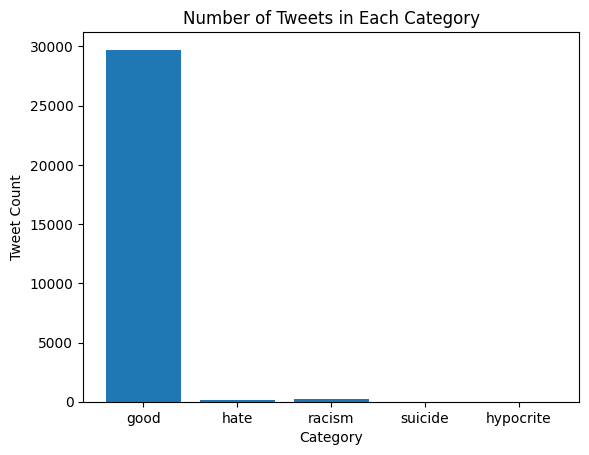

In [46]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# 2. Count how many tweets belong to each category
#    The columns of interest are: 'good', 'hate', 'racism', 'suicide', 'hypocrite'.
#    Each column is 0 or 1, so summing each column gives how many tweets have 1 in that category.
category_counts = df[['good', 'hate', 'racism', 'suicide', 'hypocrite']].sum()

# 3. Create a bar chart
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of Tweets in Each Category')
plt.xlabel('Category')
plt.ylabel('Tweet Count')
plt.show()

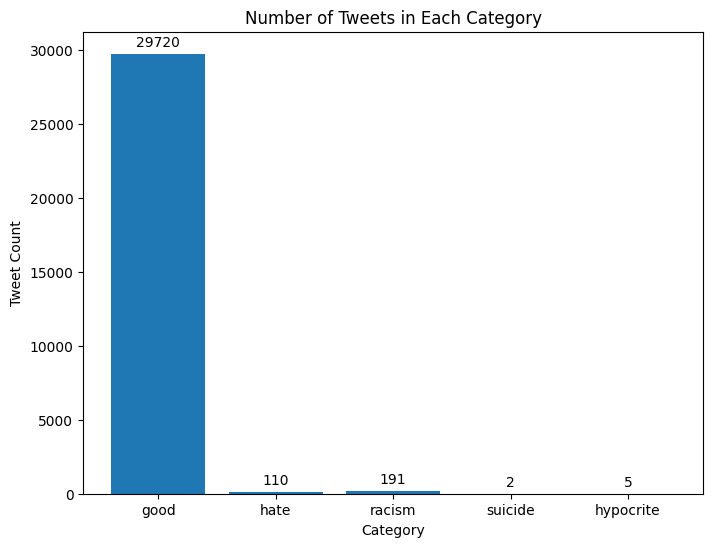

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you've already computed your category_counts:
# category_counts = df[['good','hate','racism','suicide','hypocrite']].sum()

plt.figure(figsize=(8,6))
bars = plt.bar(category_counts.index, category_counts.values)

plt.title('Number of Tweets in Each Category')
plt.xlabel('Category')
plt.ylabel('Tweet Count')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X-position: middle of the bar
        height + (0.01 * max(category_counts.values)),  # A little above the bar
        str(int(height)),                # The value as text
        ha='center', va='bottom'         # Centered horizontally, text above the bar
    )

plt.show()


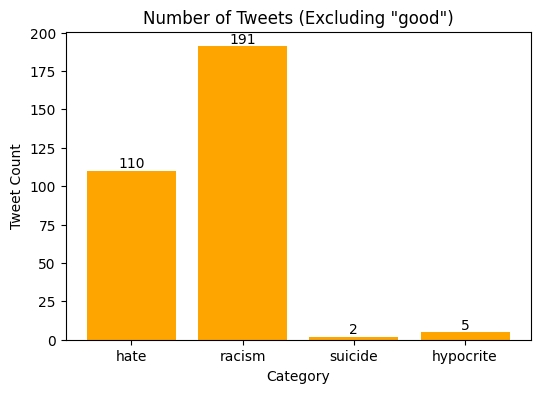

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop 'good' from your counts
small_categories = category_counts.drop('good')

plt.figure(figsize=(6,4))
bars_small = plt.bar(small_categories.index, small_categories.values, color='orange')

plt.title('Number of Tweets (Excluding "good")')
plt.xlabel('Category')
plt.ylabel('Tweet Count')

# Annotate each bar
for bar in bars_small:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, str(int(height)),
             ha='center', va='bottom')

plt.show()


In [49]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# Filter rows where racism == 1
racist_tweets = df[df['racism'] == 1]

# Show the first few
print(racist_tweets.head(10))


        id  label                                              tweet  good  \
111    112      1  @user i'm not interested in a #linguistics tha...     0   
151    152      1  yes it's  when you call #michelleobama a goril...     0   
362    363      1  trump ny co-chair makes racist remarks about m...     0   
443    444      1  fo woh officer in viral arrest video was âru...     0   
526    527      1  anti racist is a codeword for antiwhite   asia...     0   
735    736      1  standing up to racism and hate by americad not...     0   
933    934      1   is not an #opinion. racism is #degrading peop...     0   
1116  1117      1  no 'racist intent'? is this guy joking?  via @...     0   
1392  1393      1  @user buffalo school districts boots trump all...     0   
1463  1464      1  tyler perry claims âreverse racismâ by cri...     0   

      hate  racism  suicide  hypocrite  
111      0       1        0          0  
151      0       1        0          0  
362      0       1

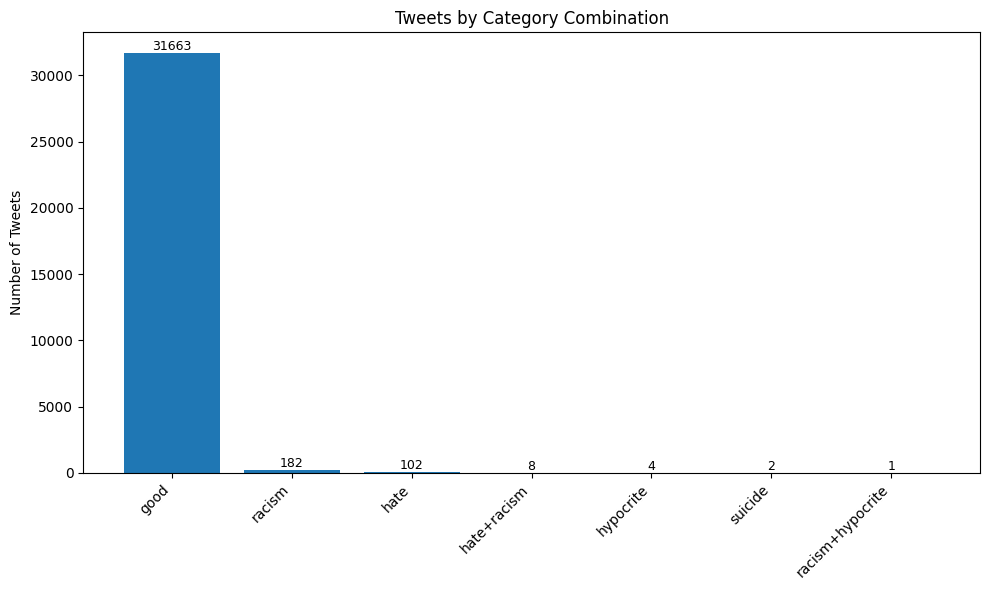

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your DataFrame (already includes the category columns)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# 2) Create a “combination label” that describes which categories each tweet has.
#    For example, if a row has hate=1, racism=1, others=0, we’ll call it "hate+racism".
def get_combination(row):
    cats = []
    if row['hate'] == 1:
        cats.append("hate")
    if row['racism'] == 1:
        cats.append("racism")
    if row['suicide'] == 1:
        cats.append("suicide")
    if row['hypocrite'] == 1:
        cats.append("hypocrite")
    if not cats:  # means it's all 0 for these
        return "good"
    return "+".join(cats)

df['category_combo'] = df.apply(get_combination, axis=1)

# 3) Count how many rows we have for each combination
combo_counts = df['category_combo'].value_counts()

# 4) Bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(combo_counts.index, combo_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Tweets by Category Combination")
plt.ylabel("Number of Tweets")

# Optional: annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


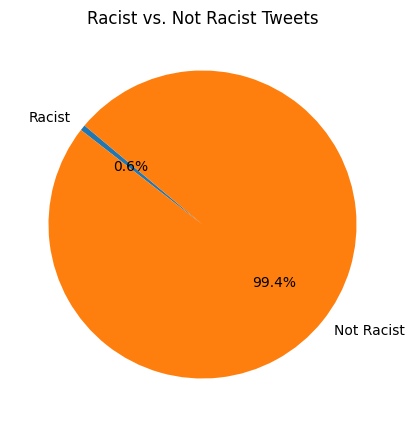

In [51]:
import matplotlib.pyplot as plt

# We have a column 'racism' which is 1 if a tweet is racist, else 0.
count_racist = df['racism'].sum()         # total tweets with racism=1
count_not_racist = len(df) - count_racist # everything else

labels = ['Racist', 'Not Racist']
sizes = [count_racist, count_not_racist]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Racist vs. Not Racist Tweets")
plt.show()


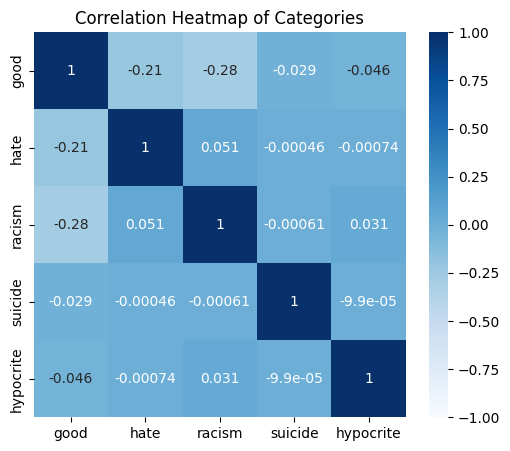

In [52]:
import seaborn as sns

# 1) Select just the category columns
category_cols = ['good','hate','racism','suicide','hypocrite']
df_cat = df[category_cols]

# 2) Calculate correlations
corr = df_cat.corr()

# 3) Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Categories")
plt.show()


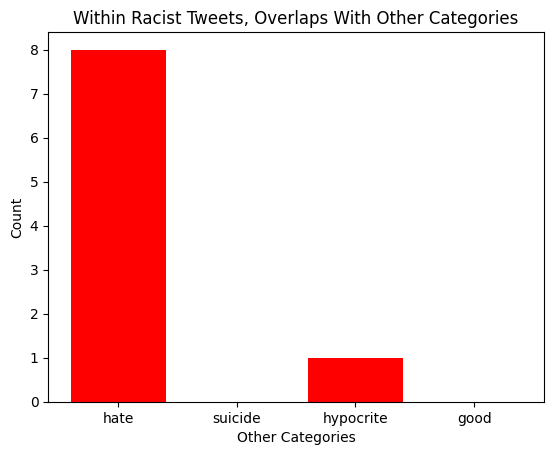

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

racist_df = df[df['racism'] == 1]  # tweets flagged as racist
counts_in_racist = {
    'hate': racist_df['hate'].sum(),
    'suicide': racist_df['suicide'].sum(),
    'hypocrite': racist_df['hypocrite'].sum(),
    'good': racist_df['good'].sum()  # Probably 0 if "good" and "racism" can't both be 1
}

keys = list(counts_in_racist.keys())
vals = list(counts_in_racist.values())

plt.bar(keys, vals, color='red')
plt.title("Within Racist Tweets, Overlaps With Other Categories")
plt.xlabel("Other Categories")
plt.ylabel("Count")
plt.show()


In [55]:
import pandas as pd

# Load your DataFrame (which has a 'racism' column)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# Filter to only rows flagged racist
racist_df = df[df['racism'] == 1]

# Count duplicates of the entire tweet text
repeated_racist_tweets = racist_df['tweet'].value_counts()

# Show the top 10 repeated tweets
print("Most common repeated racist tweets:\n")
print(repeated_racist_tweets.head(10))


Most common repeated racist tweets:

tweet
sea shepherd suppoers are racist!   #antiracism #seashepherd                                                        7
nothing would be more dangerous than to give #putinschoice the impression we accept  #stopracism #boycott?â¦       6
  sea shepherd suppoers are racist!   #antiracism #seashepherd                                                      5
sea shepherd suppoers are racist!   #antiracism #seashepherd                                                        3
trump ny co-chair makes racist remarks about michelle obama  #p2 #p21 #fyi  #tcot                                   2
 sea shepherd suppoers are racist!   #antiracism #seashepherd                                                       2
#scrutinize #savor &amp; #dispose #unbelievable #chosen #headlines in 'revolution against racism: humanity'         2
  sea shepherd suppoers are racist!  #seashepherd    #antiracism                                                    2
yes it's  whe

In [56]:
import pandas as pd

# Load your DataFrame (which has a 'suicide' column)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# Filter to only rows flagged suicidal
suicide_df = df[df['suicide'] == 1]

# Count duplicates of the entire tweet text
repeated_suicide_tweets = suicide_df['tweet'].value_counts()

# Show the top 10 repeated suicidal tweets
print("Most common repeated suicidal tweets:\n")
print(repeated_suicide_tweets.head(10))


Most common repeated suicidal tweets:

tweet
@user content: #abuse, #pedophilia, #stalking, #harassment, #gaslighting, #ableism, , #threats, #suicide, #nsfw, #self harmâ¦           1
content: #abuse, #pedophilia, #stalking, #harassment, #gaslighting, #ableism, , #threats, #suicide, #nsfw, #self harm, #rape, #incest    1
Name: count, dtype: int64


In [57]:
import pandas as pd
import re
from collections import Counter

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter Sentiment/sorted_tweets.csv')

# Extract only the tweet texts that are flagged suicidal
suicidal_tweets = df[df['suicide'] == 1]['tweet']  # This will be a Series of text

def tokenize(text):
    # A simple tokenizer that extracts alphanumeric words in lowercase
    return re.findall(r'\w+', text.lower())

all_words = []
for tweet_text in suicidal_tweets:
    all_words.extend(tokenize(tweet_text))

word_counts = Counter(all_words)
print("Most common words across all suicidal tweets:\n")
for word, freq in word_counts.most_common(20):
    print(f"{word}: {freq}")


Most common words across all suicidal tweets:

content: 2
abuse: 2
pedophilia: 2
stalking: 2
harassment: 2
gaslighting: 2
ableism: 2
threats: 2
suicide: 2
nsfw: 2
self: 2
user: 1
harmâ: 1
harm: 1
rape: 1
incest: 1


#Conclusion

The ambition of this sentiment analysis project is not just to categorize digital expressions but to illuminate the social and emotional underpinnings that resonate within the Twitter sphere. By focusing on identifying tweets that carry racist, suicidal, or other socially relevant sentiments, the project endeavors to contribute significantly to the understanding and betterment of the digital and real-world social fabric. In doing so, it underscores the transformative potential of sentiment analysis as a tool for social good, highlighting its critical role in navigating the complexities of the digital age with empathy, awareness, and action.